# Bagging and Gradient Boosting.

## Part 1. Bagging and gradient boosting.

Let's analyze how the performance of bagging and gradient boosting depends on the number of base learners in the ensemble.

In case of bagging, all the learners fit to different samples from the same data distribution $\mathbb{X} \times \mathbb{Y}$. Some of them may be overfitted, nevertheless, subsequent averaging of their individual predictions allows to mitigate this effect. The reason for this is the fact that for uncorrelated algorithms the variance of their composition is $N$ times lower than the individual's. In other words, it's highly unlikely, that all the ensemble components would overfit to some atypical object from the training set (compared to one model). When the ensemble size $N$ becomes large enough, further addition of base learners does not increase the quality.

In boosting, each algorithm is being fit to the errors of the currently constructed composition, which allows the ensemble to gradually improve the quality of the data distribution approximation. However, the increase of ensemble size $N$ may lead to overfitting, as the addition of new models into the composition further fits the training data, and eventually may decrease the generalization ability.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

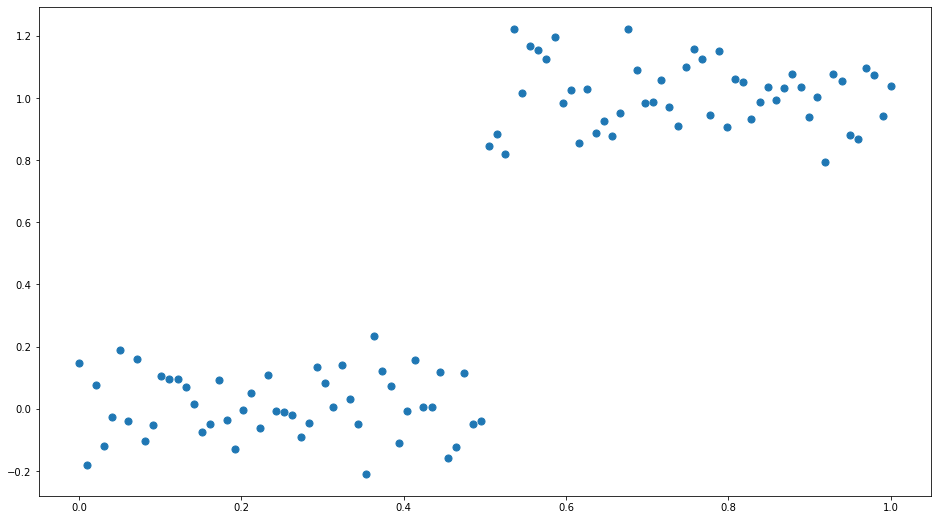

In [36]:
X_train = np.linspace(0, 1, 100)
X_test = np.linspace(0, 1, 1000)

def target(x):
    return x > 0.5

Y_train = target(X_train) + np.random.randn(X_train.shape[0])*0.1

fig, ax = plt.subplots(1, 1, figsize=(16,9))
ax.scatter(X_train, Y_train, s=50)

Firstly, let's take bagging of decision trees algorithm.

Here, the ensemble size is being gradually increased.
Let's look at how the prediction depends on the size.

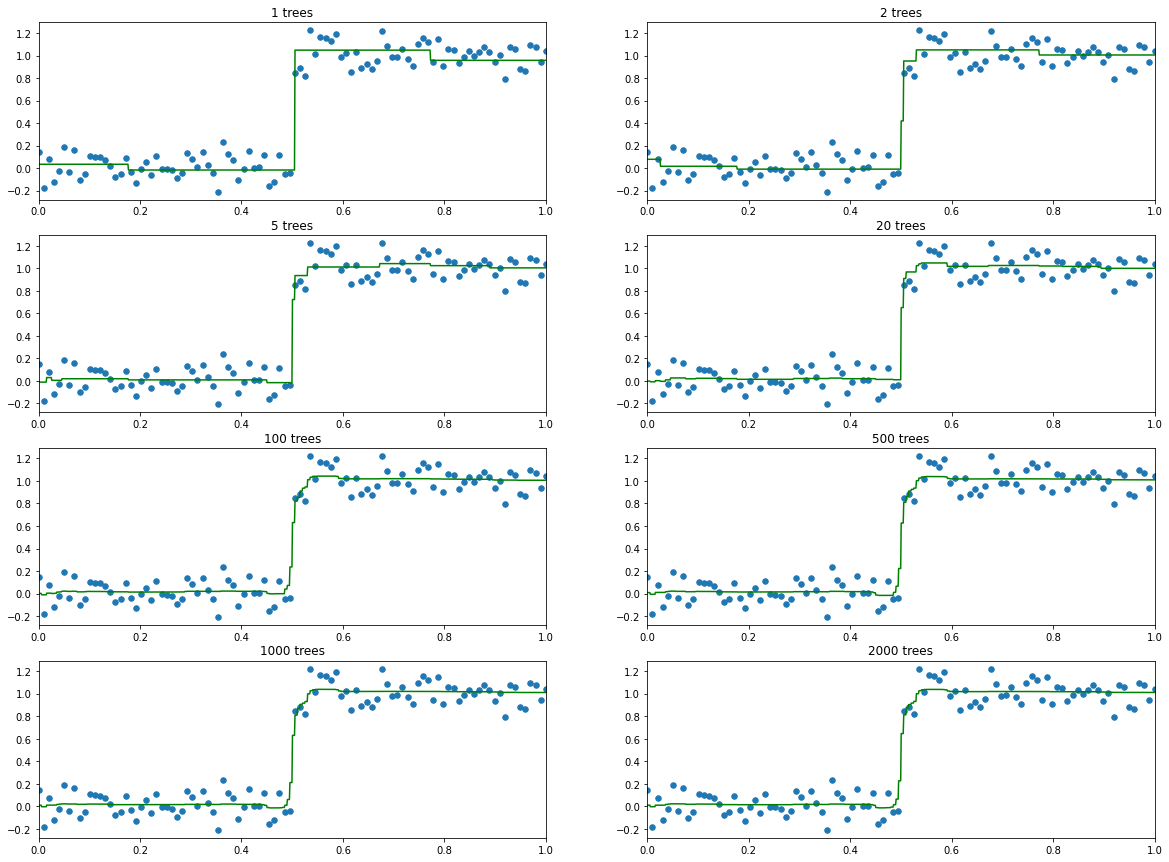

In [38]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor

reg = BaggingRegressor(DecisionTreeRegressor(max_depth=2), warm_start=True)
sizes = [1, 2, 5, 20, 100, 500, 1000, 2000]
fig, ax = plt.subplots(4, 2, figsize=(20,15))
for i, axs in enumerate(ax.flatten()):
    reg.n_estimators = sizes[i]
    reg.fit(X_train.reshape(-1, 1), Y_train)
    axs.set_xlim([0, 1])
    axs.scatter(X_train, Y_train, s=30)
    axs.plot(X_test, reg.predict(X_test.reshape(-1, 1)), c='green')
    axs.set_title(f'{sizes[i]} trees')

You can see that after a certain point the overall prediction does not change with the base learners' addition.

Now let's do the same with the gradient boosting.

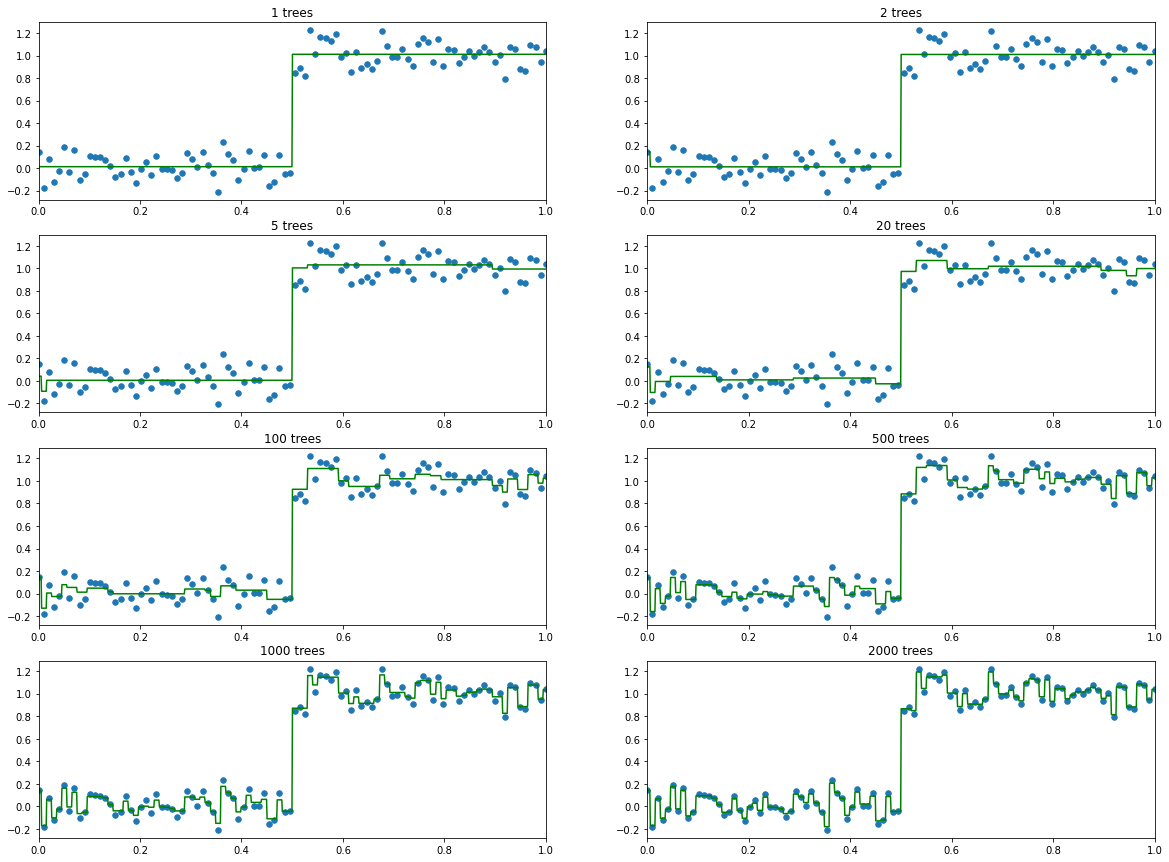

In [40]:
reg = GradientBoostingRegressor(max_depth=1, learning_rate=1, warm_start=True)
sizes = [1, 2, 5, 20, 100, 500, 1000, 2000]
fig, ax = plt.subplots(4, 2, figsize=(20,15))
for i, axs in enumerate(ax.flatten()):
    reg.n_estimators = sizes[i]
    reg.fit(X_train.reshape(-1, 1), Y_train)
    axs.set_xlim([0, 1])
    axs.scatter(X_train, Y_train, s=30)
    axs.plot(X_test, reg.predict(X_test.reshape(-1, 1)), c='green')
    axs.set_title(f'{sizes[i]} trees')

Gradient boosting quickly captured the true dependency, but afterwards began overfitting towards individual objects from the training set. As a result, models with big ensemble sizes were severly overfitted.

One can tackle this problem by picking a very simple base learner, or intentionally lowering the weight of subsequent algorithms in the composition:
$$a_N(x) = \sum_{n=0}^N \eta \gamma_N b_n(x).$$
Here, $\eta$ is the step parameter, which controls the influence of new ensemble components.

Such an approach makes training slower compared to bagging, though, makes the final model less overfitted. Still, one should keep in mind that overfitting can happen for any $\eta$ in the limit of infinite ensemble size.

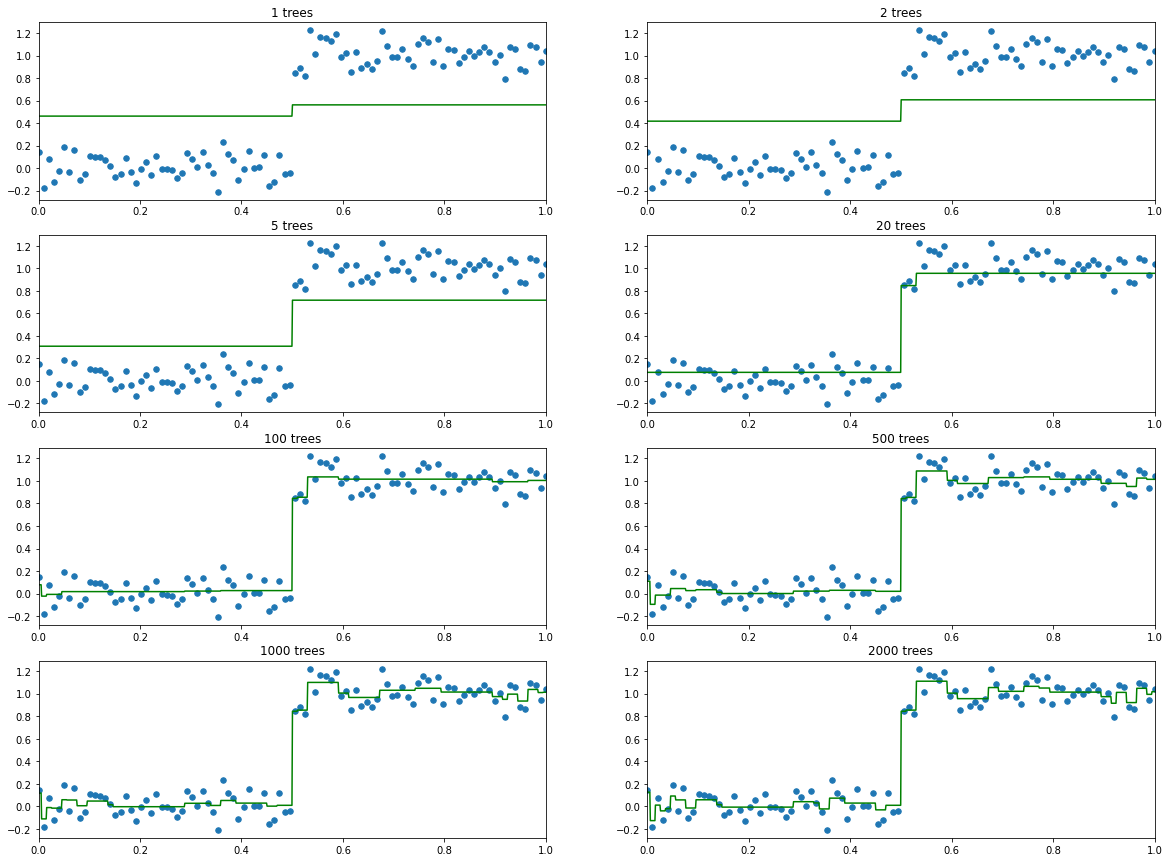

In [41]:
reg = GradientBoostingRegressor(max_depth=1, learning_rate=0.1, warm_start=True)
sizes = [1, 2, 5, 20, 100, 500, 1000, 2000]
fig, ax = plt.subplots(4, 2, figsize=(20,15))
for i, axs in enumerate(ax.flatten()):
    reg.n_estimators = sizes[i]
    reg.fit(X_train.reshape(-1, 1), Y_train)
    axs.set_xlim([0, 1])
    axs.scatter(X_train, Y_train, s=30)
    axs.plot(X_test, reg.predict(X_test.reshape(-1, 1)), c='green')
    axs.set_title(f'{sizes[i]} trees')

Let's look at the described phenomenon on a more realistic dataset.

In [44]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

ds = datasets.load_diabetes()
X = ds.data
Y = ds.target
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.5, test_size=0.5)

max_estimators = 300

model = BaggingRegressor(warm_start=True)
error_train_bagging = []
error_test_bagging = []
for i in range(1, max_estimators + 1):
    model.n_estimators = i
    model.fit(X_train, y_train)
    error_train_bagging.append(1 - model.score(X_train, y_train))
    error_test_bagging.append(1 - model.score(X_test, y_test))
    
model = GradientBoostingRegressor(warm_start=True, max_depth=2, learning_rate=0.1)
error_train_boosting = []
error_test_boosting = []
for i in range(1, max_estimators + 1):
    model.n_estimators = i
    model.fit(X_train, y_train)
    error_train_boosting.append(1 - model.score(X_train, y_train))
    error_test_boosting.append(1 - model.score(X_test, y_test))

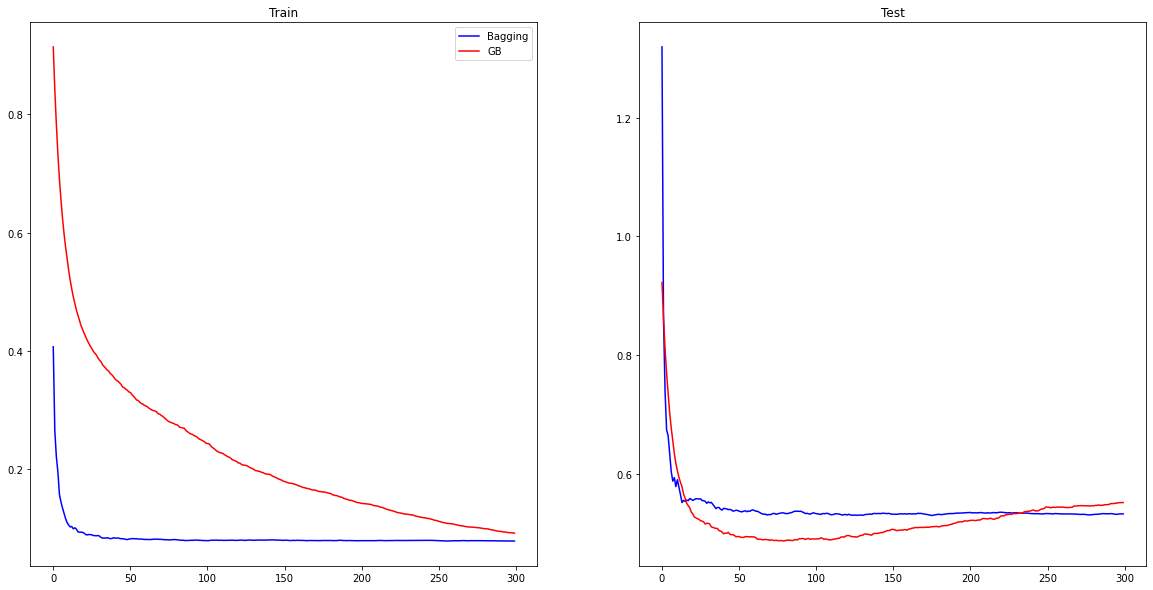

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].plot(error_train_bagging, label="Bagging", c='blue')
ax[0].plot(error_train_boosting, label="GB", c='red')
ax[0].set_title("Train")
ax[0].legend()

ax[1].plot(error_test_bagging, label="Bagging", c='blue')
ax[1].plot(error_test_boosting, label="GB", c='red')
ax[1].set_title("Test")
ax[0].legend()

## Part 2. Multilabel classification with Decision Trees, Random Forests, and Gradient Boosting.

In the second part of our practice session, we will apply each method to the classification task and do optimal model selection.

In [47]:
X = datasets.load_digits().data
y = datasets.load_digits().target

In [49]:
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

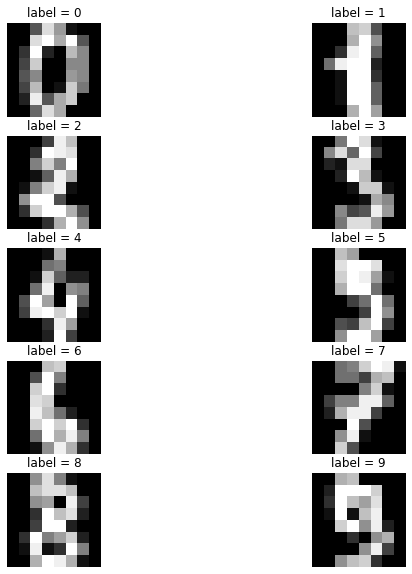

In [51]:
fig, ax = plt.subplots(5, 2, figsize=(10,10))
for i, axs in enumerate(ax.flatten()):
    img = X[i].reshape(8, 8)
    axs.imshow(img, cmap='gray')
    axs.set_title(f"label = {i}")
    axs.axis('off')

In [53]:
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                    shuffle=True, random_state=42)

In [56]:
# Decision trees

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

model = DecisionTreeClassifier()
model.fit(x_train, y_train)
print(f"Decision tree accuracy: {accuracy_score(y_test, model.predict(x_test))}")

Decision tree accuracy: 0.8527777777777777


In [62]:
# Random forest

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(x_train, y_train)
print(f"Default Random forest accuracy: {accuracy_score(y_test, model.predict(x_test))}")

sizes = [5, 10, 100, 500, 1000]

for size in sizes:
    model = RandomForestClassifier()
    model.n_estimators = size
    model.fit(x_train, y_train)
    print(f"Random forest with {size} trees accuracy: {accuracy_score(y_test, model.predict(x_test))}")

Default Random forest accuracy: 0.975
Random forest with 5 trees accuracy: 0.9416666666666667
Random forest with 10 trees accuracy: 0.9611111111111111
Random forest with 100 trees accuracy: 0.9722222222222222
Random forest with 500 trees accuracy: 0.975
Random forest with 1000 trees accuracy: 0.975


In [63]:
# GB

from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier()
model.fit(x_train, y_train)
print(f"Default GB accuracy: {accuracy_score(y_test, model.predict(x_test))}")

sizes = [5, 10, 100, 500, 1000]

for size in sizes:
    model = RandomForestClassifier()
    model.n_estimators = size
    model.fit(x_train, y_train)
    print(f"GB with {size} trees accuracy: {accuracy_score(y_test, model.predict(x_test))}")

Default GB accuracy: 0.9722222222222222
GB with 5 trees accuracy: 0.925
GB with 10 trees accuracy: 0.9583333333333334
GB with 100 trees accuracy: 0.9805555555555555
GB with 500 trees accuracy: 0.975
GB with 1000 trees accuracy: 0.975


# XGBOOST
[Features](https://arxiv.org/pdf/1603.02754.pdf):

1. Parallelization, optimization and sparse/missing data support

2. Base algorithm approximates the direction, computred using second-order loss function derivatives.

3. Regularized Learning Objective: penalty for leaf number and coefficient norms are added.

4. Weighted Quantile Sketch algorithm proposed to select tree node split points.

Wall time: 25.3 s


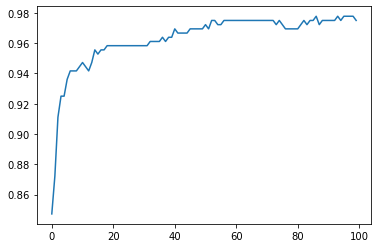

In [69]:
%%time
import xgboost as xgb

dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

param = {
    'max_depth': 3, #max tree depth
    'eta': 0.3, #lr
    #'silent': 1, #log verbosity
    'objective': 'multi:softprob', # objective function(for multiclass)
    'num_class': 10
}
num_round = 100 #boosting iterations
acc = []
for i in range(1, num_round + 1):
    bst = xgb.train(param, dtrain, i)
    preds = bst.predict(dtest)
    best_preds = np.asarray([np.argmax(line) for line in preds])
    #print(f"XGBOOST accuracy with {i} iter : {accuracy_score(best_preds, y_test)}")
    acc.append(accuracy_score(best_preds, y_test))
    
plt.plot(acc)